In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Helper functions

In [4]:
cut_dict = {
    'Fair' : 0,
    'Very Good' : 1,
    'Good' : 2,
    'Premium' : 3,
    'Ideal' : 4
}
color_dict = {y:x for x, y in cut_dict.items()}

def show_scoring_results(clasification_type, model):
    print(f"{clasification_type} F1 micro train score: {f1_score(diamonds_labelss_train, model.predict(diamonds_features_train), average = 'micro')}")
    print(f"{clasification_type} F1 micro train score: {f1_score(diamonds_labelss_test, model.predict(diamonds_features_test), average = 'micro')}")


def plot_confusion_matrix(estimator, features, labels, title = None):
    predictions = estimator.predict(features)
    cm = confusion_matrix(labels, predictions, normalize = "all")
    plt.figure(figsize = (10, 10))
    if title is not None:
        plt.title(label = title)
    sns.heatmap(
        cm ,
        annot = True,
        fmt = ".2%",
        cmap = plt.cm.Blues,
        xticklabels = np.array([color_dict[val] for val in estimator.classes_]),
        yticklabels = np.array([color_dict[val] for val in estimator.classes_])
    )
    plt.show()

# 1. Abstract

The task of this paper will be to compare five classification algorithms.

The Algorithms that will be subject of the paper are: Logistic Regression, Decision Tree, Random Foresr, Gausian SVM and Linear SVM.

The data set that will be used is call **diamonds**, dataset contains the prices and other attributes of almost 54,000 diamonds.

Within this task I will try to find out what is the **cut quality** of any given diamond depending on the other features 

# 2. Data Reading
#### 2.1) Retirve Data

In [5]:
diamonds_data = pd.read_csv("data/diamonds.csv")
diamonds_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### 2.2) Features Explanation
* **Carat**: Carat weight of the Diamond.
* **Cut**: Describe cut quality of the diamond
    + Quality in increasing order Fair, Good, Very Good, Premium, Ideal.
* **Color **:  Color of the Diamond.
    + With D being the best and J the worst.
* **Clarity**: Diamond Clarity refers to the absence of the Inclusions and Blemishes.
    + (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3
* **Depth**: The Height of a Diamond, measured from the Culet to the table, divided by its average Girdle Diameter. 
    + depth total depth percentage = z / mean(x, y) = 2 * z / (x + y)
* **Table**: The Width of the Diamond's Table expressed as a Percentage of its Average Diameter. 
    + table width of top of diamond relative to widest point
* **Price**: the Price of the Diamond.
* **X**: Length of the Diamond in mm.
* **Y**: Width of the Diamond in mm.
* **Z**: Height of the Diamond in mm.

Qualitative Features (Categorical) : Cut, Color, Clarity.

Quantitative Features (Numerical) : Carat, Depth , Table , Price , X , Y, Z.

In [6]:
diamonds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


#### 2.3) Remove index column that will not be needed

In [6]:
diamonds_data = diamonds_data.drop("Unnamed: 0", axis = 1)

#### 2.4) Describe and analyze all the non-categorial values in he data set

We can see that there is zero values in dimentions column which is a sign for missing data, because no diamond can have zero dimention

In this situation I will examin the dataset and if there are few samples with missing dimentions will delete tham

In [7]:
diamonds_data.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


In [8]:
diamonds_data.shape

(53940, 10)

In [9]:
diamonds_data.loc[(diamonds_data["x"]==0) | (diamonds_data["y"]==0) | (diamonds_data["z"]==0)].shape

(20, 10)

I will delete the lines that have zero in any dimention feature

In [10]:
diamonds_data = diamonds_data[(diamonds_data[["x","y","z"]] != 0).all(axis =1)]
diamonds_data.shape

(53920, 10)

From correlation data we can conclude:
* **Depth is inversely related to Price.**
    + This is because if a Diamond's Depth percentage is too large or small the Diamond will become 'Dark' in appearance because it will no longer return an Attractive amount of light.
* **The Price of the Diamond is highly correlated to Carat, and its Dimensions.**

* **The Weight (Carat) of a diamond has the most significant impact on its Price.**
    + Since, the larger a stone is, the Rarer it is, one 2 carat diamond will be more 'Expensive' than the total cost of two 1 Carat Diamonds of the same Quality.
* **The Length(x) , Width(y) and Height(z) seems to be higly related to Price and even each other.**

In [11]:
diamonds_data.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028259,0.181646,0.921592,0.977779,0.953991,0.961048
depth,0.028259,1.000000,-0.295733,-0.010729,-0.025017,-0.029069,0.095023
table,0.181646,-0.295733,1.000000,0.127245,0.196097,0.184493,0.152483
price,0.921592,-0.010729,0.127245,1.000000,0.887231,0.867864,0.868206
x,0.977779,-0.025017,0.196097,0.887231,1.000000,0.974918,0.975435
y,0.953991,-0.029069,0.184493,0.867864,0.974918,1.000000,0.956744
z,0.961048,0.095023,0.152483,0.868206,0.975435,0.956744,1.000000


#### 2.5)  Label feature - Cut  values has to be changed with numeric one 

In [12]:
colors = diamonds_data["cut"].replace(cut_dict)

In [13]:
colors.shape

(53920,)

#### 2.6) Data visualizatrion

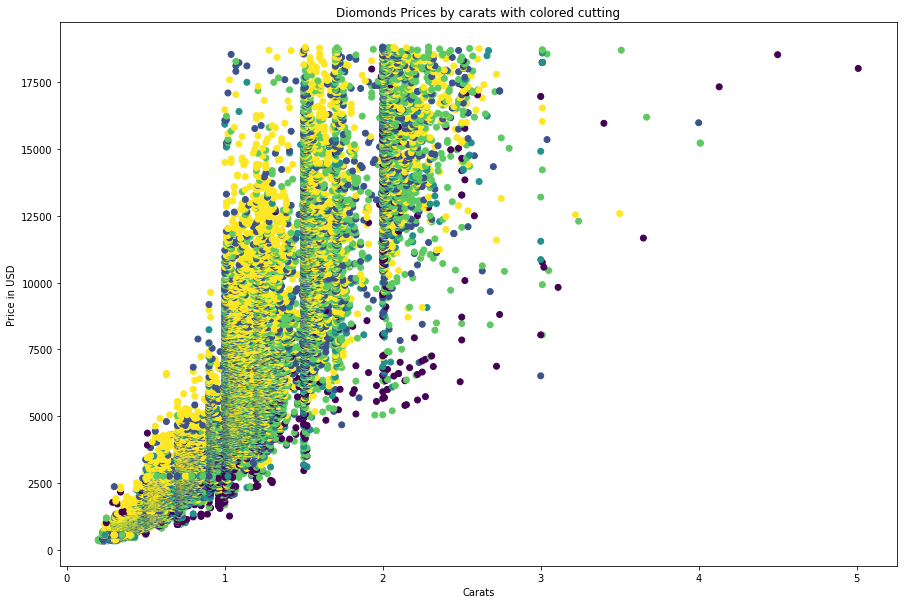

In [14]:
plt.figure(figsize=(15,10))
plt.scatter(diamonds_data["carat"], diamonds_data["price"], c = colors)
plt.xlabel("Carats")
plt.ylabel("Price in USD")
plt.title("Diomonds Prices by carats with colored cutting")
plt.show()

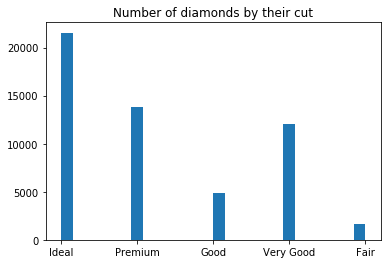

In [15]:
plt.hist(diamonds_data["cut"], bins = "fd")
plt.title("Number of diamonds by their cut")
plt.show()

# 3. Features engineering
#### 3.1) Devide labels and features 

In [16]:
diamonds_labels = colors.astype("int64")
diamonds_features = diamonds_data.drop("cut", axis = 1)

In [17]:
print(diamonds_labels.shape)
print(diamonds_features.shape)

(53920,)
(53920, 9)


In [18]:
diamonds_features.head()

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### 3.2) Convert categorial columns to dummies

In [19]:
diamonds_features = pd.get_dummies(diamonds_features)
diamonds_features.shape

(53920, 22)

In [20]:
diamonds_features.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,0,...,0,1,0,0,0,1,0,0,0,0


#### 3.3) Normalize data

In [21]:
scale = StandardScaler()
diamonds_features[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']] = scale.fit_transform(diamonds_features[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']])
diamonds_features.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198204,-0.174203,-1.099725,-0.904132,-1.591573,-1.539219,-1.580084,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.240417,-1.361090,1.585988,-0.904132,-1.645173,-1.662014,-1.750896,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,-1.198204,-3.385781,3.376463,-0.903881,-1.502241,-1.460280,-1.750896,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.071566,0.454149,0.243131,-0.902125,-1.368242,-1.319943,-1.295396,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-1.029353,1.082501,0.243131,-0.901875,-1.243176,-1.214690,-1.124583,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [22]:
diamonds_features[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53920.0,-2.289977e-14,1.000009,-1.261523,-0.839396,-0.206205,0.511411,8.890635
depth,53920.0,-2.795830e-15,1.000009,-13.090331,-0.523288,0.035248,0.523966,12.043756
table,53920.0,1.116263e-14,1.000009,-6.471152,-0.652106,-0.204488,0.690750,16.805029
price,53920.0,-4.567901e-15,1.000009,-0.904132,-0.747883,-0.383722,0.349178,3.734913
x,53920.0,1.150167e-15,1.000009,-1.788105,-0.912646,-0.028253,0.722141,4.474109
y,53920.0,-3.277413e-15,1.000009,-1.802350,-0.890162,-0.021829,0.706168,46.631351
z,53920.0,2.775953e-15,1.000009,-3.515961,-0.896833,-0.014300,0.711654,40.226327


#### 3.4) Split data to test and train sets


In [23]:
diamonds_features_train, diamonds_features_test,diamonds_labelss_train,diamonds_labelss_test = train_test_split(
    diamonds_features,
    diamonds_labels,
    train_size = 0.8,
    stratify = diamonds_labels)
diamonds_features_train.shape, diamonds_features_test.shape, diamonds_labelss_train.shape,diamonds_labelss_test.shape

((43136, 22), (10784, 22), (43136,), (10784,))

#### 3.5) Prepare the cross-validation fold

In [24]:
k_fold = StratifiedKFold(n_splits = 5)

# 4. Perform different classification approaches to data set

## 4.1) Logistic regression

The only parameter we will change in order to receive better results is C parameter. The parameter C is the the inverse of regularization strength in Logistic Regression.

#### Step 1

In [26]:
parameters = {
    "C": [1e-3,0.001,0.1,10, 100, 1000]
}
logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Logistic regression, best params", grid_search.best_params_)
print("Logistic regression; best score:", grid_search.best_score_)

Logistic regression, best params {'C': 1000}
Logistic regression; best score: 0.6553692010383031


#### Step 2

In [28]:
parameters = {
    "C": [500, 750, 1000, 1250, 1500, 2000]
}
logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)

print("Logistic regression, best params", grid_search.best_params_)

show_scoring_results("Logistic Regression", grid_search)

Logistic regression, best params {'C': 1000}
Logistic Regression F1 micro train score: 0.656481824925816
Logistic Regression F1 micro train score: 0.6497589020771514


In [26]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

              precision    recall  f1-score   support

           0       0.80      0.48      0.60      1287
           1       0.50      0.47      0.48      9665
           2       0.55      0.13      0.20      3922
           3       0.66      0.72      0.69     11024
           4       0.72      0.85      0.78     17238

    accuracy                           0.65     43136
   macro avg       0.64      0.53      0.55     43136
weighted avg       0.64      0.65      0.63     43136



We can see that there is no quality increase and even if we find the best value of teh C parameter the F1 metric will be hardy increase

Below we can observe the confusion matrix and classification report of Logistic Regression on test set

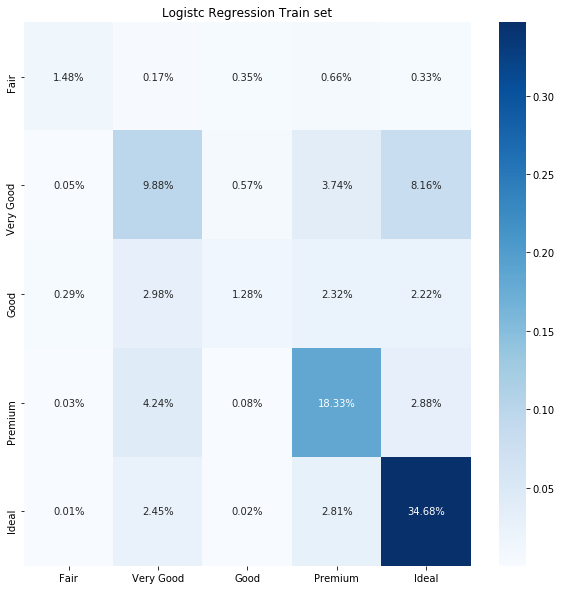

In [29]:
plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Logistc Regression Train set")

In [30]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.78      0.44      0.56       322
           1       0.49      0.44      0.46      2416
           2       0.54      0.13      0.21       980
           3       0.65      0.70      0.67      2756
           4       0.72      0.87      0.79      4310

    accuracy                           0.65     10784
   macro avg       0.64      0.52      0.54     10784
weighted avg       0.64      0.65      0.63     10784



## 4.2) Decision Tree

Initially I will try to find the best parameters for most important parameters which are: max_depth and max_leaf_nodes and later will continue in narrow limits.

Desision tree parameters:
* **max_depth**: This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data.
* **min_samples_split**: Represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. 
* **min_samples_leaf** The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.
* **max_leaf_nodes** Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

#### Step 1

In [31]:
parameters = {
    "max_depth":[1, 5, 7, 15, 20],
    "min_samples_leaf": [ 2, 5, 10, 12],
    "max_leaf_nodes": [5, 10, 20]
}
decision_tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Decision tree, best params", grid_search.best_params_)
print("Decision Tree; best score:", grid_search.best_score_)

Decision tree, best params {'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 2}
Decision Tree; best score: 0.7295763013759509


In [32]:
show_scoring_results("Decision Tree", grid_search)

Decision Tree F1 micro train score: 0.7308512611275965
Decision Tree F1 micro train score: 0.7244992581602375


#### Step 2
From score results we can see that Decision tree is better in finding diamonds cut we can proceed with hyper parameter tuning

Please note that confusion matrix is performed on Train test and the label is by mistake Test 

Decision tree, best params {'max_depth': 12, 'max_leaf_nodes': 25, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision tree, best scoring 0.7320568560318251
Decision Tree F1 micro train score: 0.7342127225519288
Decision Tree F1 micro train score: 0.7286721068249258


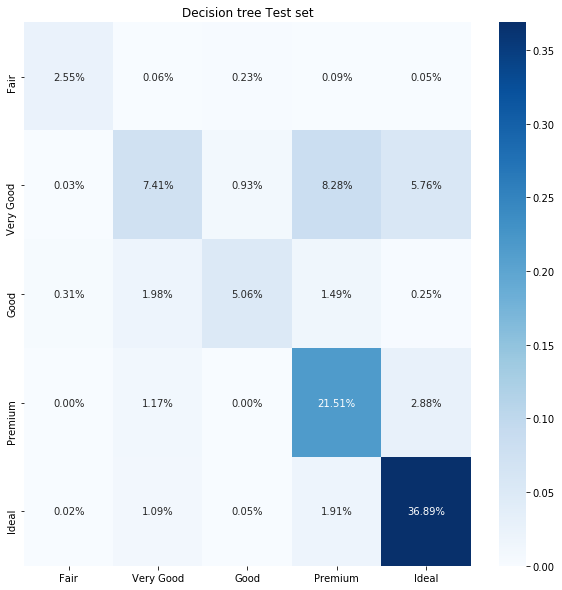

In [33]:
parameters = {
    "max_depth":[12, 14, 15, 16, 17, 18],
    "min_samples_leaf": [ 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    "max_leaf_nodes": [15, 17, 20, 23, 25]
}
decision_tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Decision tree, best params", grid_search.best_params_)
print("Decision tree, best scoring", grid_search.best_score_)

show_scoring_results("Decision Tree", grid_search)

plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Decision tree Test set")

#### Step 3

We can proceed with tuning but F1 score improvments is not that great and below we can observe the highest F1 score for this set.

Decision tree, best params {'max_depth': 10, 'max_leaf_nodes': 27, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision tree, best scoring 0.7341664607117233
Decision Tree F1 micro train score: 0.736878709198813
Decision Tree F1 micro train score: 0.7307121661721068


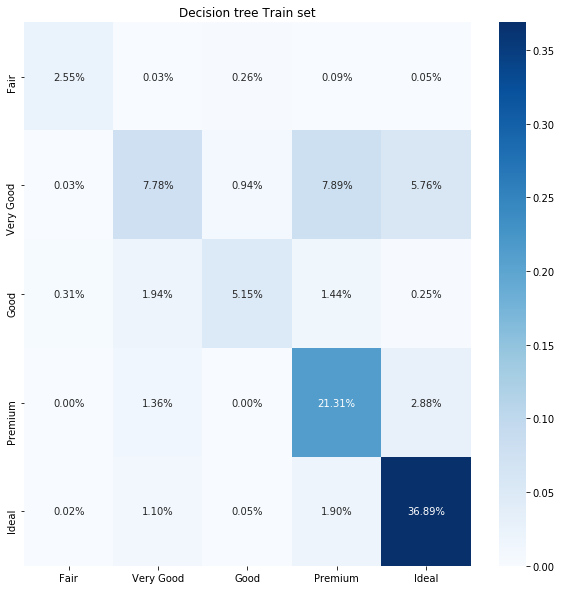

In [34]:
parameters = {
    "max_depth":[10, 11 ,12, 13, 14],
    "min_samples_leaf": [ 2, 3 ],
    'min_samples_split': [2, 5],
    "max_leaf_nodes": [23, 24, 25, 26, 27]
}
decision_tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Decision tree, best params", grid_search.best_params_)
print("Decision tree, best scoring", grid_search.best_score_)

show_scoring_results("Decision Tree", grid_search)

plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Decision tree Train set")

In [35]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1287
           1       0.64      0.35      0.45      9665
           2       0.80      0.57      0.66      3922
           3       0.65      0.83      0.73     11024
           4       0.80      0.92      0.86     17238

    accuracy                           0.74     43136
   macro avg       0.76      0.70      0.71     43136
weighted avg       0.73      0.74      0.72     43136



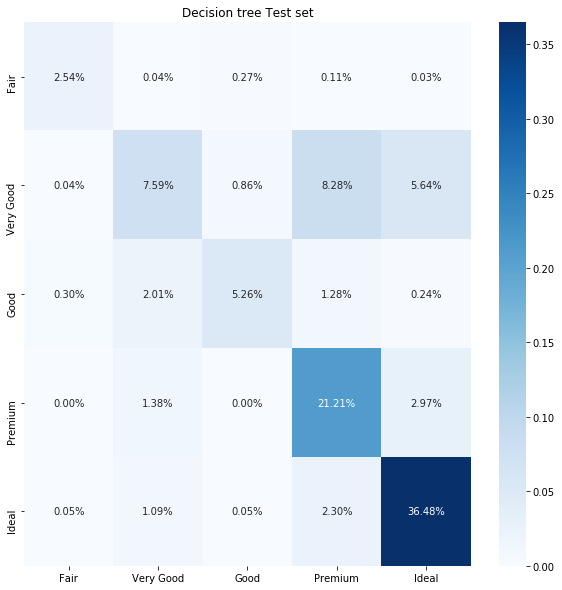

In [36]:
plot_confusion_matrix(grid_search, diamonds_features_test, diamonds_labelss_test, "Decision tree Test set")

In [37]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       322
           1       0.63      0.34      0.44      2416
           2       0.82      0.58      0.68       980
           3       0.64      0.83      0.72      2756
           4       0.80      0.91      0.86      4310

    accuracy                           0.73     10784
   macro avg       0.75      0.70      0.71     10784
weighted avg       0.73      0.73      0.71     10784



# 4.3) Random Forest

In addition to Random Forest parameters there is one mor ewhich is the most important :
* **n_estimators**: The number of trees in the forest.

#### Step 1
From metrics below we can see that the petcentage of the right predictions for Test set is almost 100% but on Test drops significantly. This is a clear sign for **overfitting**.

In [38]:
parameters = {
    "n_estimators": [100, 200, 300] ,
    "max_depth": [20, 50, 100]
}
random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Random Forest, best params", grid_search.best_params_)

Random Forest, best params {'max_depth': 50, 'n_estimators': 300}


In [39]:
show_scoring_results("Random Forest", grid_search)

Random Forest F1 micro train score: 0.9999536350148368
Random Forest F1 micro train score: 0.7656713649851632


#### Step 2

Again overfitting is observed

Random Forest, best params {'max_depth': 120, 'min_samples_split': 5, 'n_estimators': 600}
Random Forest F1 micro train score: 0.9672431379821959
Random Forest F1 micro train score: 0.7698442136498517


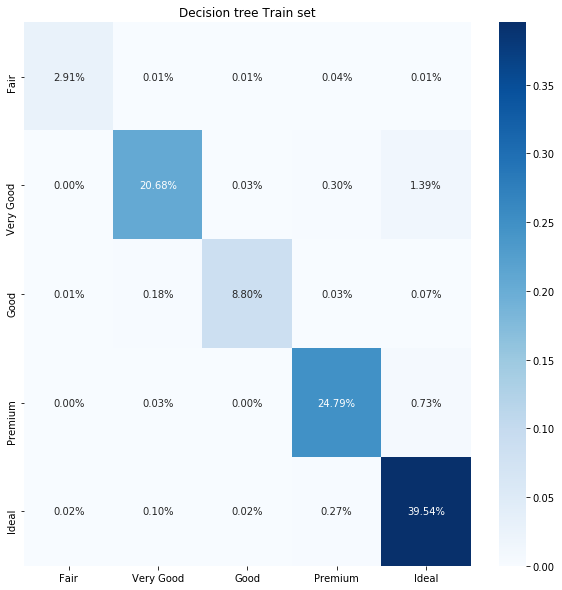

In [40]:
parameters = {
     'max_depth': [80, 100, 120],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 300, 400, 600]
}
random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Random Forest, best params", grid_search.best_params_)

show_scoring_results("Random Forest", grid_search)
plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Decision tree Train set")

In [41]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1287
           1       0.98      0.92      0.95      9665
           2       0.99      0.97      0.98      3922
           3       0.97      0.97      0.97     11024
           4       0.95      0.99      0.97     17238

    accuracy                           0.97     43136
   macro avg       0.98      0.97      0.97     43136
weighted avg       0.97      0.97      0.97     43136



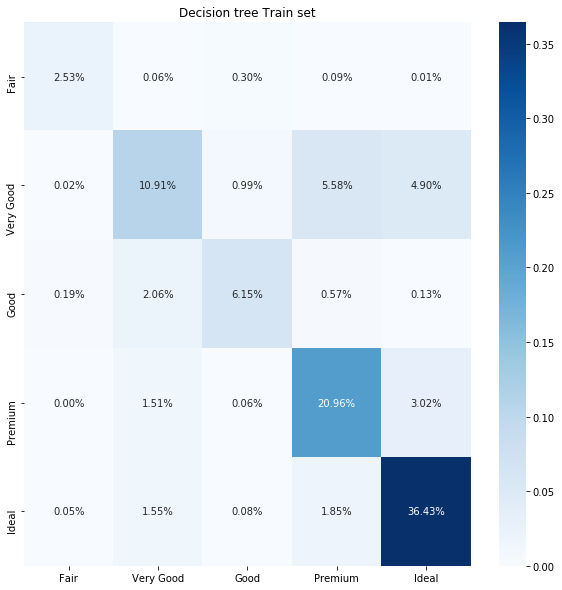

In [42]:
plot_confusion_matrix(grid_search, diamonds_features_test, diamonds_labelss_test, "Decision tree Train set")

In [43]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       322
           1       0.68      0.49      0.57      2416
           2       0.81      0.68      0.74       980
           3       0.72      0.82      0.77      2756
           4       0.82      0.91      0.86      4310

    accuracy                           0.77     10784
   macro avg       0.79      0.75      0.76     10784
weighted avg       0.76      0.77      0.76     10784



## 4.4) Gaussian SVM

There is one additional hyper parameter for this classification and it is:
*  **gamma**: decides that how much curvature we want in a decision boundary and is related to **sigma**. Higher gamma more curves

#### Step 1

In [44]:
parameters = {
    "C" : [10, 15, 20, 50, 200],
    "gamma": [0.001, 0.01, 0.1, 0.2]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)

Gausian SVM, best params {'C': 20, 'gamma': 0.1}


In [45]:
show_scoring_results("Gausian SVC", grid_search)

Gausian SVC F1 micro train score: 0.7998423590504451
Gausian SVC F1 micro train score: 0.7691951038575666


#### Step 2

In [46]:
parameters = {
    "C" : [ 16, 18, 20, 23, 25],
    "gamma": [0.05, 0.1, 0.15, ]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)

Gausian SVM, best params {'C': 18, 'gamma': 0.1}


In [77]:
show_scoring_results("Gausian SVC", grid_search)

Gausian SVC train Accuracy: 0.8071912091988132
Gausian SVC test Accuracy: 0.773089762611276
Gausian SVC F1 micro train score: 0.8071912091988132
Gausian SVC F1 micro test score: 0.773089762611276


#### Step 3

In [47]:
parameters = {
    "C" : [ 47, 48, 49, 50, 51, 52, 53],
    "gamma": [0.05, 0.075, 0.1, 0.125,0.15 ]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)
show_scoring_results("Gausian SVC", grid_search)

Gausian SVM, best params {'C': 48, 'gamma': 0.075}
Gausian SVC F1 micro train score: 0.8005841988130564
Gausian SVC F1 micro train score: 0.7703078635014837


#### Best results for Gausian SVM

Gausian SVM, best params {'C': 48, 'gamma': 0.075}
Gausian SVC F1 micro train score: 0.8005841988130564
Gausian SVC F1 micro train score: 0.7703078635014837


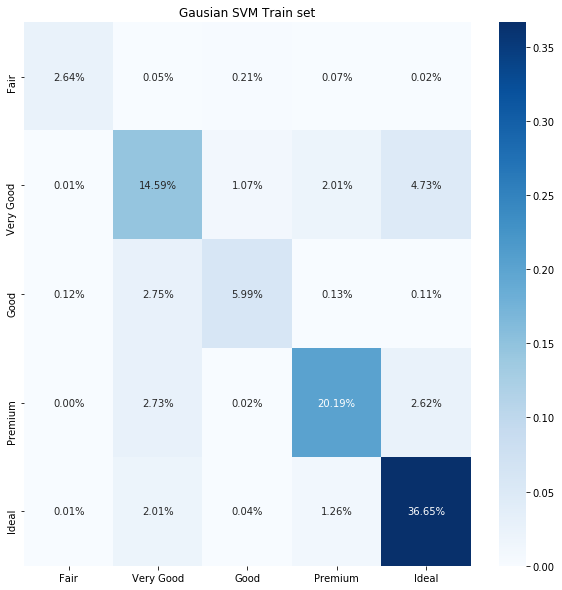

In [48]:
parameters = {
    "C" : [ 48 ],
    "gamma": [ 0.075 ]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)

show_scoring_results("Gausian SVC", grid_search)
plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Gausian SVM Train set")

In [28]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

              precision    recall  f1-score   support

           0       0.96      0.90      0.92      1287
           1       0.66      0.65      0.66      9665
           2       0.83      0.67      0.74      3922
           3       0.85      0.79      0.82     11024
           4       0.83      0.91      0.87     17238

    accuracy                           0.80     43136
   macro avg       0.82      0.78      0.80     43136
weighted avg       0.80      0.80      0.80     43136



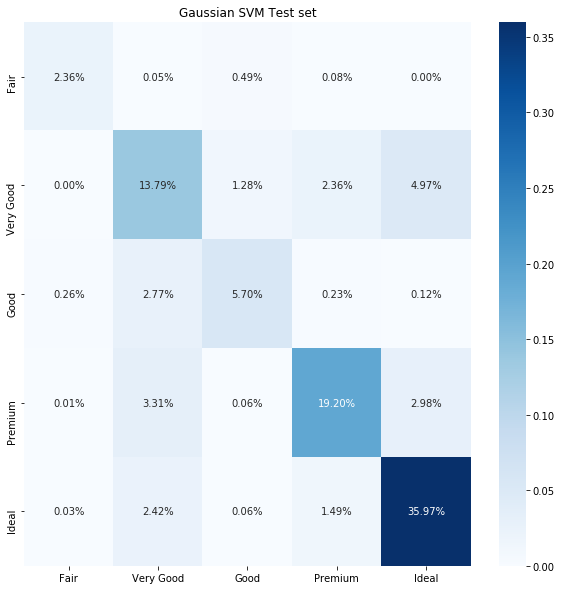

In [49]:
plot_confusion_matrix(grid_search, diamonds_features_test, diamonds_labelss_test, "Gaussian SVM Test set")

In [50]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       322
           1       0.62      0.62      0.62      2416
           2       0.75      0.63      0.68       980
           3       0.82      0.75      0.78      2756
           4       0.82      0.90      0.86      4310

    accuracy                           0.77     10784
   macro avg       0.78      0.74      0.76     10784
weighted avg       0.77      0.77      0.77     10784



## 4.5) Liera SVM

#### Step 1

In [51]:
parameters = {
    "C" : [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20]
}
linear_svm_model = LinearSVC()
grid_search = GridSearchCV(linear_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Linear SVM, best params", grid_search.best_params_)
show_scoring_results("Linear SVC", grid_search)

Linear SVM, best params {'C': 20}
Linear SVC F1 micro train score: 0.640161350148368
Linear SVC F1 micro train score: 0.6327893175074184


#### Step 2

Linear SVM, best params {'C': 13}
Linear SVC F1 micro train score: 0.6336702522255193
Linear SVC F1 micro train score: 0.6261127596439169


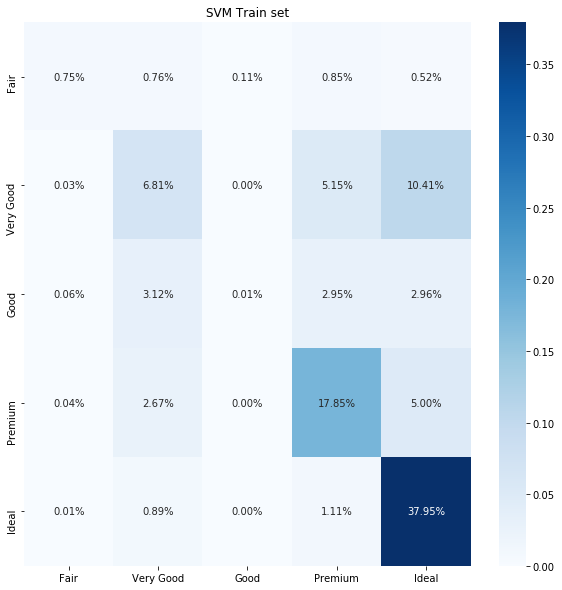

In [52]:
parameters = {
    "C" : [ 8, 9, 10, 12, 13]
}
linear_svm_model = LinearSVC()
grid_search = GridSearchCV(linear_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Linear SVM, best params", grid_search.best_params_)

show_scoring_results("Linear SVC", grid_search)
plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "SVM Train set")

In [30]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

              precision    recall  f1-score   support

           0       0.91      0.31      0.46      1287
           1       0.49      0.33      0.40      9665
           2       0.00      0.00      0.00      3922
           3       0.63      0.73      0.68     11024
           4       0.68      0.92      0.79     17238

    accuracy                           0.64     43136
   macro avg       0.54      0.46      0.46     43136
weighted avg       0.57      0.64      0.59     43136



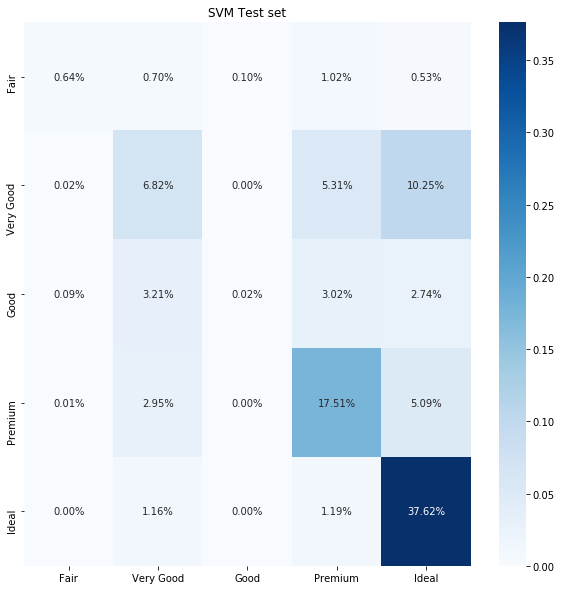

In [53]:
plot_confusion_matrix(grid_search, diamonds_features_test, diamonds_labelss_test, "SVM Test set")

In [54]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.84      0.21      0.34       322
           1       0.46      0.30      0.37      2416
           2       0.15      0.00      0.00       980
           3       0.62      0.69      0.65      2756
           4       0.67      0.94      0.78      4310

    accuracy                           0.63     10784
   macro avg       0.55      0.43      0.43     10784
weighted avg       0.57      0.63      0.57     10784



# 5 Algorithm estimations

Algorithm estimation is based on **F1-scoring** which is a statiscical analysis of binary clasification and is a mesure of accuracy. **F1-scoring** is calculated from **precision** and **recall** where precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. The highest possible value of an F-score is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.

Corresponding formulas can be found below:

* **Precision** $$Precision=\frac{TruePositive}{TruePositive + FalsePositive}=\frac{TruePositive}{TotalPredictedPositive}$$
* **Recall**  $$Recall=\frac{TruePositive}{TruePositive + FalseNegative}=\frac{TruePositive}{TotalActualPositive}$$
* **F1-score** $$F1=2\frac{Precision*Recall}{Precision+Recall}$$

Below we can find in a table gathered all the information from made tests:

|   | Test Set  | Test Set   |  Test Set  |  Test Set  |  Train Set |  Train Set | Train Set  | Train Set  |
|---|---|---|---|---|---|---|---|---|
|   |F1 macro   |F1 weighted   |F1 micro   |Accuracy   |F1 macro   |F1 weighted   |F1 micro   |Accuracy|
|Logistic Regression   |0.54   |0.63   |0.65   |0.65   |0.53   |0.65   |0.66   |0.65   |
|Decision Tree  |0.71   |0.71   |0.73   |0.73   |0.71   |0.72   |0.74   |0.74   |
|Random Forest   |0.76   |0.76   |0.77   |0.97   |0.97   |0.97   |0.97   |0.97   |
|Gaussian SVM   |0.77   |0.77   |0.77   |0.77   |0.8   |0.8   |0.8   |0.8   |
|Linear SVM   |0.43   |0.57   |0.63   |0.63   |0.46   |0.64   |0.63   |0.64   |

# 6 Conclusion

From tables above and all the confusion marixes we can make teh conclusion that the "best" algorithm for diamonds data set is Random Forest. But the great difference between Train and Test metrics is clear evidence for great overfitting and using this model for claifying may tur deeply wrong. The secon "best" algorythm is Gaussian SVM but unfortunately this algorithm is so "heavy" that if the dataset was bigger probbaly even good computer cannot deal with a propper parameter tuning. My personal oppinion is that for this given set the best approach will be to use Decision Tree since bothe other Ligistic Regression and Linear SVM are not performing well with this given task

## 7 Used resources

* https://www.kaggle.com/shivam2503/diamonds
* https://www.wikipedia.org/
* https://scikit-learn.org/stable/
* https://stackoverflow.com/

